# **Understanding the Heartbleed Bug**

## Introduction
The Heartbleed Bug is a serious vulnerability in the popular OpenSSL cryptographic software library. It allows stealing the information protected by the SSL/TLS encryption, which is used to secure the internet. This bug allows anyone on the internet to read the memory of systems protected by the vulnerable versions of OpenSSL.

## The Heartbeat Protocol
Before diving into the bug itself, it's crucial to understand the heartbeat protocol in TLS. A heartbeat message is usually sent to ensure that the other end is still connected and responsive. This message contains a payload, its length, and some random padding data.

#### **Heartbeat Message Format**
```plaintext
| Type (1 byte) | Payload Length (2 bytes) | Payload (variable) | Padding (variable) |
```


### Simulating a Heartbeat Request
Let's create a sample heartbeat request. The type is `0x01`, indicating a request, and the payload is `HelloRANDOM`.

In [1]:
from avicenna_formalizations.heartbeat import heartbeat_string_to_hex
# Simulating a Heartbeat request
s = "\x01 5 Hello XY"
heartbeat_request = heartbeat_string_to_hex(s)
print("Heartbeat Request:", heartbeat_request)

Heartbeat Request: 01 00 05 48 65 6C 6C 6F 58 59


## Simulating the Heartbleed Bug
Given the heartbeat request, if the payload length is set longer than the actual payload, a vulnerable server might send back more data than it should, revealing sensitive information from its memory.


In [2]:
s = "\x01 5 Hello XY"
heartbeat_request = heartbeat_string_to_hex(s)
print("Heartbeat Request:", heartbeat_request)

Heartbeat Request: 01 00 05 48 65 6C 6C 6F 58 59


In [3]:
from avicenna_formalizations.heartbeat import heartbeat_response

response = heartbeat_response(heartbeat_request)
print("Heartbeat Response:", response)

Heartbeat Response: 02 00 05 48 65 6C 6C 6F


In [4]:
from avicenna_formalizations.heartbeat import hex_to_heartbeat_string

decoded_response = hex_to_heartbeat_string(response)
print("Decoded Response:", decoded_response)

Decoded Response: \x02 5 Hello 


Now we lets check the following heartbeat request:

In [5]:
s = "\x01 100 Hello XY"
heartbeat_request = heartbeat_string_to_hex(s)
print("Heartbeat Request:", heartbeat_request)

Heartbeat Request: 01 00 64 48 65 6C 6C 6F 58 59


In [6]:
# Getting a response from the vulnerable server
response = heartbeat_response(heartbeat_request)
print("Heartbeat Response:", response)

Heartbeat Response: 02 00 64 48 65 6C 6C 6F 58 59 2F 4C 4A 71 29 6F 57 5F 65 72 3B 6C 69 50 7A 71 7E 65 5E 72 6E 63 53 40 56 6C 24 3E 58 59 6A 64 44 2B 21 72 76 71 59 54 3F 3D 71 4B 58 7D 6A 36 23 54 47 4B 3D 5A 30 35 31 2C 69 72 53 61 64 42 77 7C 4B 7E 53 4B 3E 4C 72 6D 50 6F 55 62 5A 6D 79 36 4F 70 74 4E 68 2E 7D 43 44 76 4D


In [7]:
decoded_response = hex_to_heartbeat_string(response)
print("Decoded Response:", decoded_response)

Decoded Response: \x02 100 HelloXY/LJq)oW_er;liPzq~e^rncS@Vl$>XYjdD+!rvqYT?=qKX}j6#TGK=Z051,irSadBw|K~SK>LrmPoUbZmy6OptNh.}CDvM 


In [8]:
def test_heartbleed_vulnerability(request_str, response_hex):
    """Test if the Heartbleed bug occurred based on the request and response."""
    
    # Extract the specified payload length from the request string format
    # Given your format "\x01 8 Hello abc", we extract the number after the space and before the payload.
    specified_payload_length = int(request_str.split()[1])
    
    # Extract the actual payload from the request string (assuming space-separated format)
    actual_payload = request_str.split()[2][:specified_payload_length].encode('utf-8')
    
    # Convert the response hex string to bytes
    response_byte_data = bytes.fromhex(response_hex.replace(" ", ""))
    
    # Extract the payload (and potentially extra data) from the response
    response_payload_and_extra = response_byte_data[3:3+specified_payload_length+len(actual_payload)]

    # Compare the response payload to the request payload
    # If they're not the same or if there's extra data, then there's a potential Heartbleed vulnerability
    if response_payload_and_extra != actual_payload:
        return True  # Heartbleed bug might have occurred
    
    return False

In [9]:
from avicenna.oracle import OracleResult
def oracle(inp):
    try:
        heartbeat_request_str = str(inp)
        hex_request = heartbeat_string_to_hex(heartbeat_request_str)
        response = heartbeat_response(hex_request)
        is_vulnerable = test_heartbleed_vulnerability(heartbeat_request_str, response)
        print("Is the server vulnerable to Heartbleed?", is_vulnerable)
    except OverflowError:
        return OracleResult.UNDEF
    return OracleResult.BUG if is_vulnerable else OracleResult.NO_BUG

In [10]:
oracle("\x01 65535 Hello abc")

Is the server vulnerable to Heartbleed? True


<OracleResult.BUG: 'BUG'>

### Conclusion
The Heartbleed bug is a severe vulnerability that exposes sensitive data due to incorrect handling of heartbeat requests. It emphasizes the need for rigorous testing and scrutiny of cryptographic software and protocols.


In the case of the Heartbleed bug:

- A malicious client can send a heartbeat request with a payload of small size (let's say 1 byte) but specify a much larger payload length (e.g., 65535 bytes).
- A vulnerable server will then respond with a heartbeat response that contains the 1-byte payload and up to 65534 bytes of memory contents that follow it, which is the heart of the vulnerability. The padding is not the focal point here; the danger lies in the extra memory content returned as payload due to erroneous handling of the specified payload length.

In [11]:
from isla.fuzzer import GrammarFuzzer
from avicenna_formalizations.heartbeat import grammar

g = GrammarFuzzer(grammar)

for _ in range(10):
    inp = g.fuzz()
    print(inp.encode())
    print(oracle(inp))

b'\x01 8 jNK AN'
Is the server vulnerable to Heartbleed? True
BUG
b'\x01 47 f u'
Is the server vulnerable to Heartbleed? True
BUG
b'\x01 512 T D'
Is the server vulnerable to Heartbleed? True
BUG
b'\x01 9 N rtN'
Is the server vulnerable to Heartbleed? True
BUG
b'\x01 81 w p'
Is the server vulnerable to Heartbleed? True
BUG
b'\x01 232 oU F'
Is the server vulnerable to Heartbleed? True
BUG
b'\x01 3 p nH'
Is the server vulnerable to Heartbleed? True
BUG
b'\x01 5467 R mHJzdJMV'
Is the server vulnerable to Heartbleed? True
BUG
b'\x01 7 hSvQl LxH'
Is the server vulnerable to Heartbleed? True
BUG
b'\x01 9507748 AC mA'
UNDEF


avicenna :: 2023-08-10 21:16:26,439 :: INFO     :: Starting Avicenna.
avicenna :: 2023-08-10 21:16:26,523 :: INFO     :: Starting Iteration 0
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


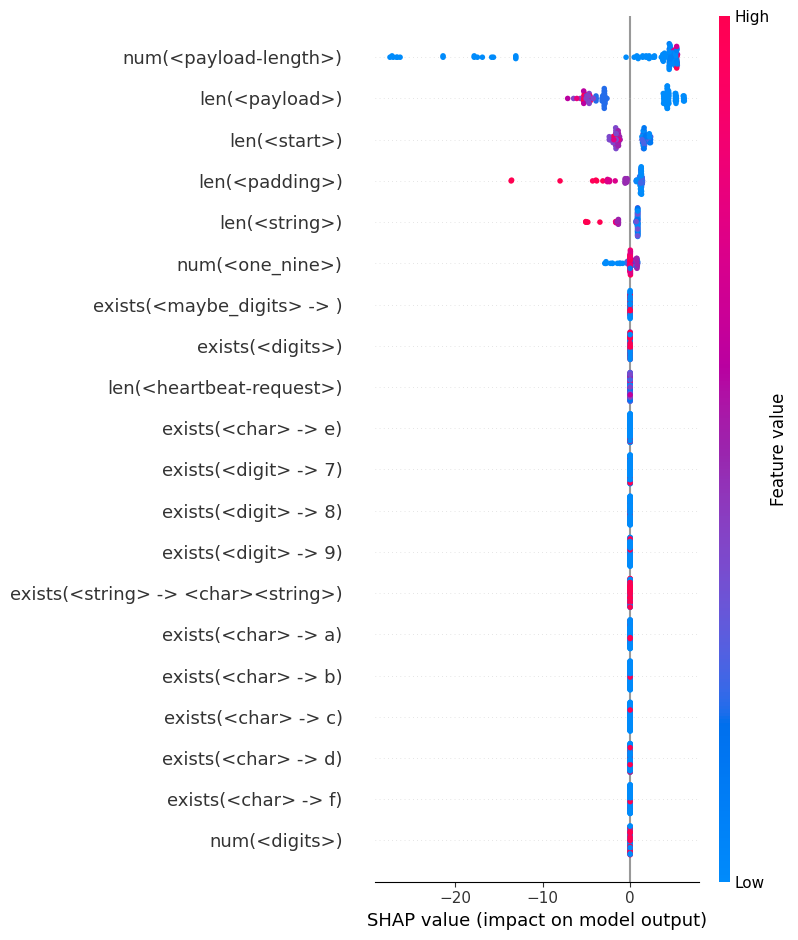

root :: 2023-08-10 21:16:27,357 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:16:27,361 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.
learner :: 2023-08-10 21:16:27,451 :: INFO     :: Keeping 2 positive examples for candidate generation.
learner :: 2023-08-10 21:16:27,523 :: INFO     :: Found 152 invariant candidates.
learner :: 2023-08-10 21:16:27,524 :: INFO     :: Evaluating Recall.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:16:35,382 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:16:35,681 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:16:35,950 :: INFO     :: Found 2 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:16:35,951 :: INFO     :: Eval new stuff
avicenna :: 2023-08-10 21:16:35,967 :: INFO     :: Starting Iteration 1
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


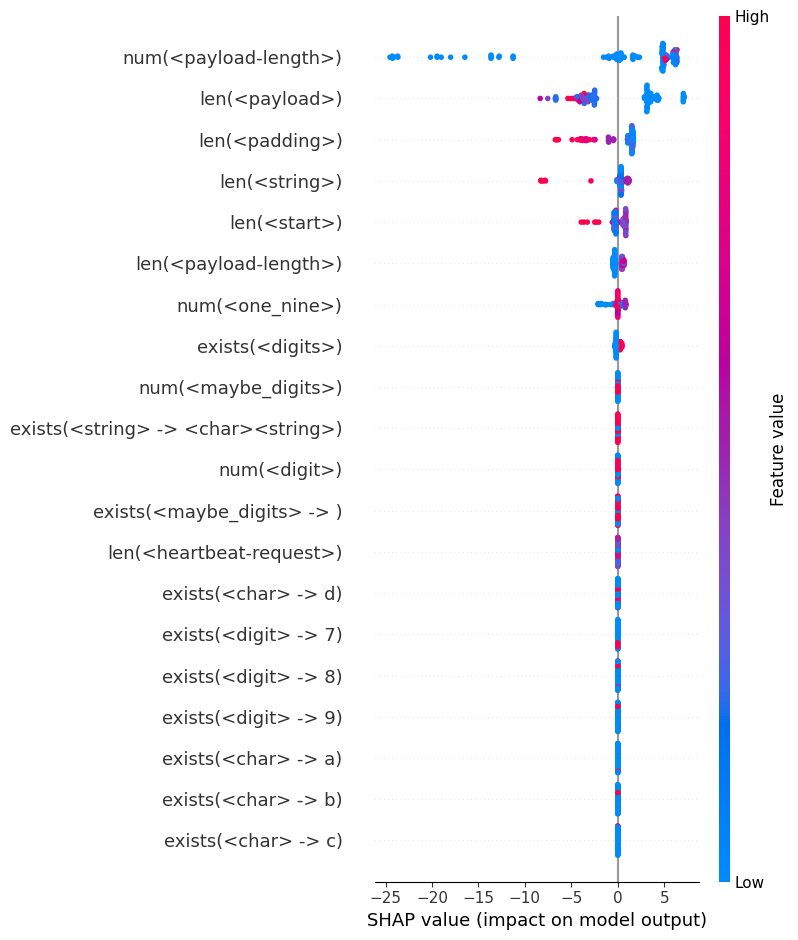

root :: 2023-08-10 21:16:36,712 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:16:36,714 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.
learner :: 2023-08-10 21:16:36,800 :: INFO     :: Keeping 2 positive examples for candidate generation.
learner :: 2023-08-10 21:16:36,861 :: INFO     :: Found 152 invariant candidates.
learner :: 2023-08-10 21:16:36,861 :: INFO     :: Evaluating Recall.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:16:44,007 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:16:44,071 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:16:44,346 :: INFO     :: Found 3 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:16:44,347 :: INFO     :: Eval new stuff
avicenna :: 2023-08-10 21:16:44,361 :: INFO     :: Starting Iteration 2
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


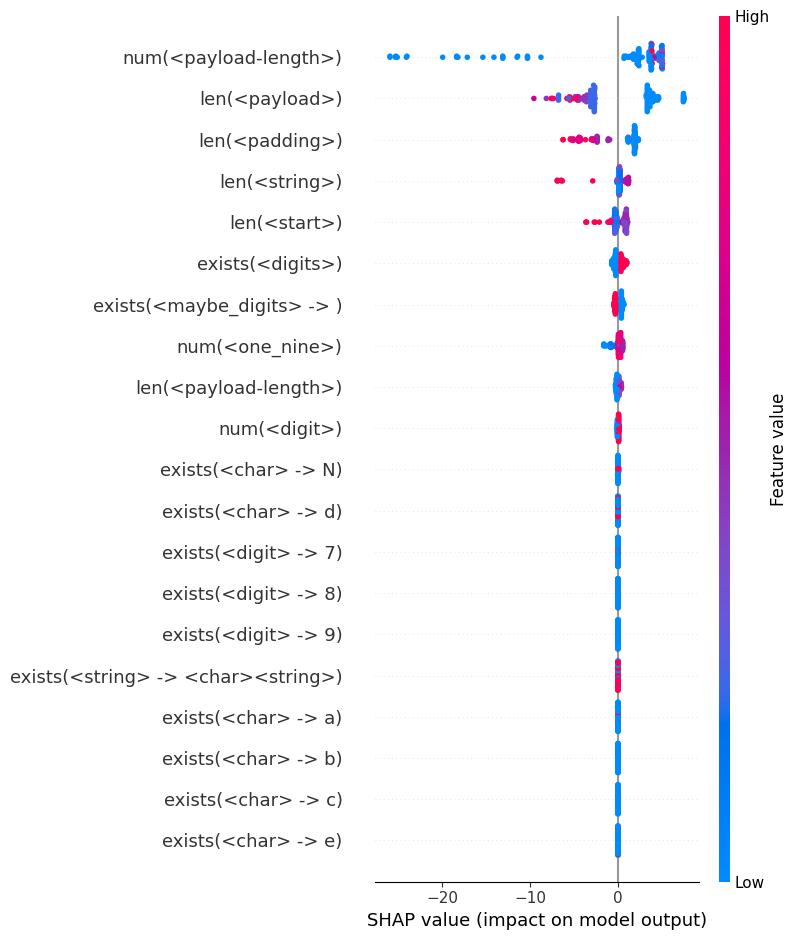

root :: 2023-08-10 21:16:45,284 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:16:45,287 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.
learner :: 2023-08-10 21:16:45,397 :: INFO     :: Keeping 2 positive examples for candidate generation.
learner :: 2023-08-10 21:16:45,459 :: INFO     :: Found 152 invariant candidates.
learner :: 2023-08-10 21:16:45,460 :: INFO     :: Evaluating Recall.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:16:54,066 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:16:54,087 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:16:54,372 :: INFO     :: Found 3 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:16:54,373 :: INFO     :: Eval new stuff
avicenna :: 2023-08-10 21:16:54,387 :: INFO     :: Starting Iteration 3
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


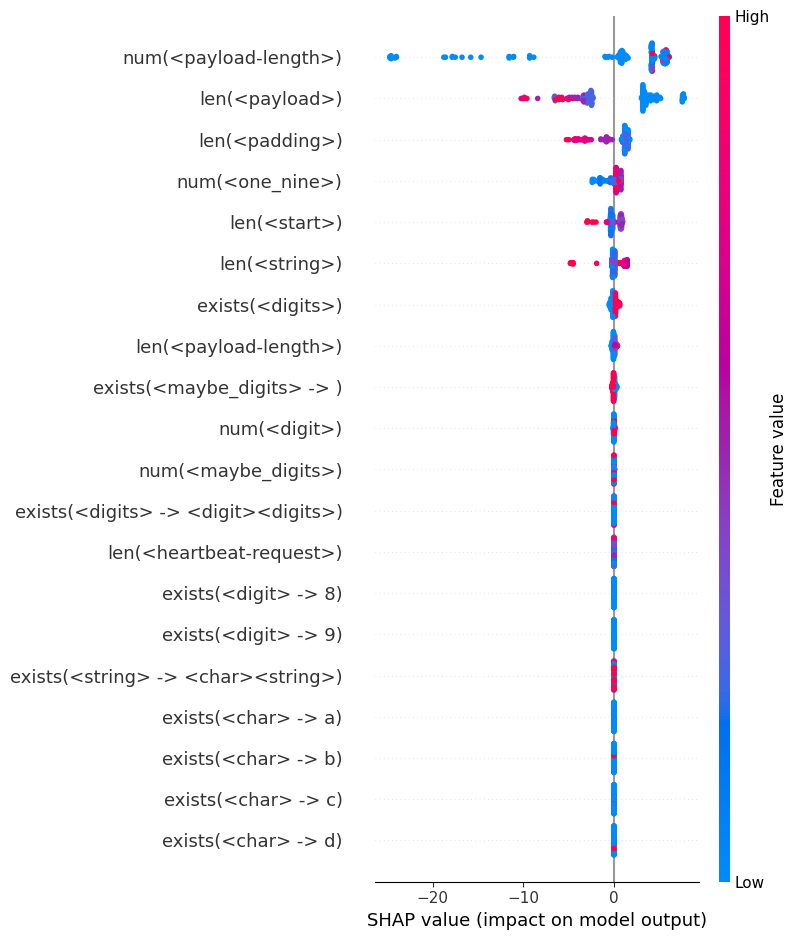

root :: 2023-08-10 21:16:55,059 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:16:55,062 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.
learner :: 2023-08-10 21:16:55,193 :: INFO     :: Keeping 2 positive examples for candidate generation.
learner :: 2023-08-10 21:16:55,253 :: INFO     :: Found 152 invariant candidates.
learner :: 2023-08-10 21:16:55,254 :: INFO     :: Evaluating Recall.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:17:05,626 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:17:05,687 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:17:05,981 :: INFO     :: Found 5 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:17:05,982 :: INFO     :: Eval new stuff
avicenna :: 2023-08-10 21:17:05,998 :: INFO     :: Starting Iteration 4
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


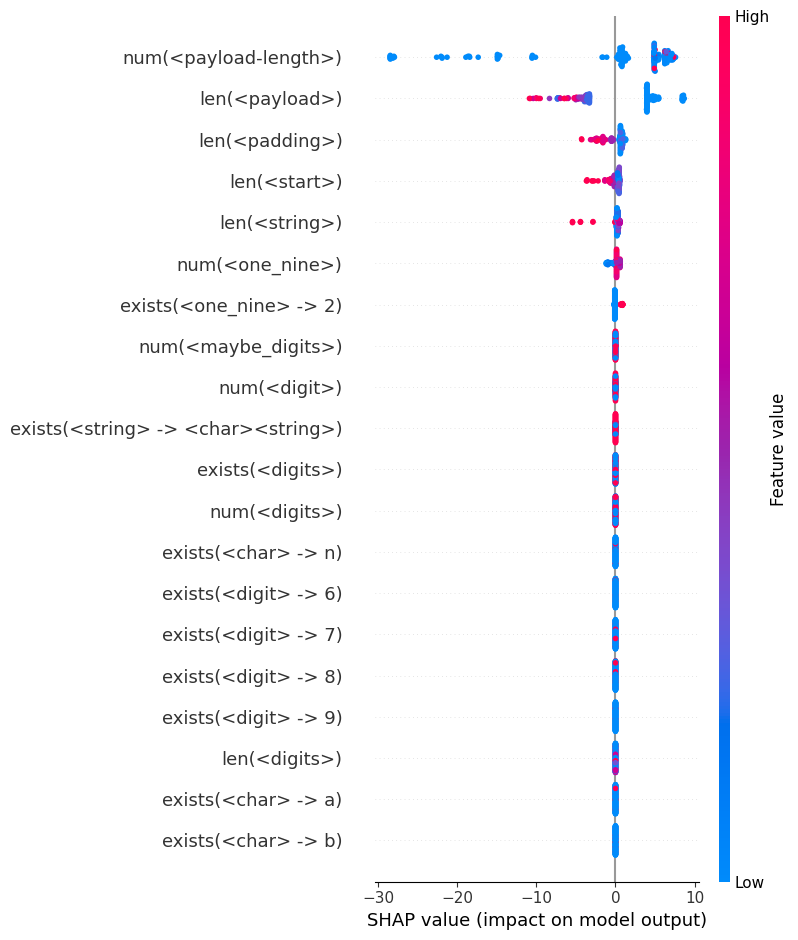

root :: 2023-08-10 21:17:06,741 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:17:06,744 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.
learner :: 2023-08-10 21:17:06,925 :: INFO     :: Keeping 2 positive examples for candidate generation.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:17:06,991 :: INFO     :: Found 153 invariant candidates.
learner :: 2023-08-10 21:17:06,992 :: INFO     :: Evaluating Recall.
learner :: 2023-08-10 21:17:18,899 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:17:18,965 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:17:19,421 :: INFO     :: Found 5 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:17:19,422 :: INFO     :: Eval new stuff
avicenna :: 2023-08-10 21:17:19,437 :: INFO     :: Starting Iteration 5
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


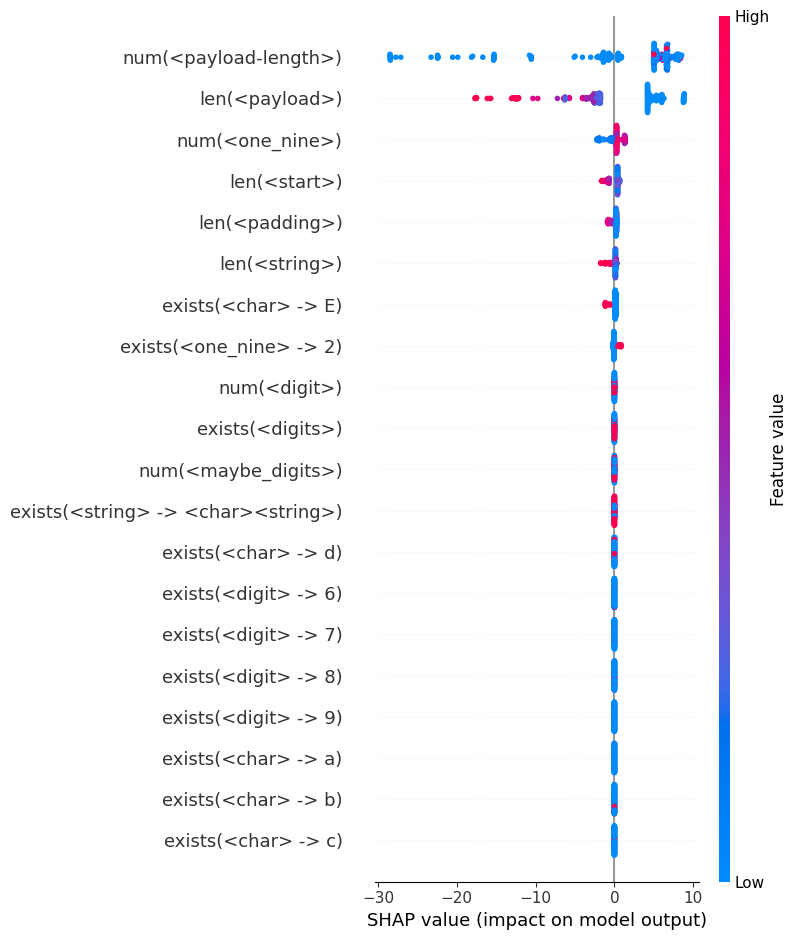

root :: 2023-08-10 21:17:20,139 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:17:20,143 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), exists(<digits> -> <digit><digits>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:17:20,362 :: INFO     :: Keeping 2 positive examples for candidate generation.
learner :: 2023-08-10 21:17:20,433 :: INFO     :: Found 153 invariant candidates.
learner :: 2023-08-10 21:17:20,434 :: INFO     :: Evaluating Recall.
learner :: 2023-08-10 21:17:33,411 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:17:33,457 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:17:33,943 :: INFO     :: Found 5 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:17:33,943 :: INFO     :: Eval new stuff
avicenna :: 2023-08-10 21:17:33,958 :: INFO     :: Starting Iteration 6
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


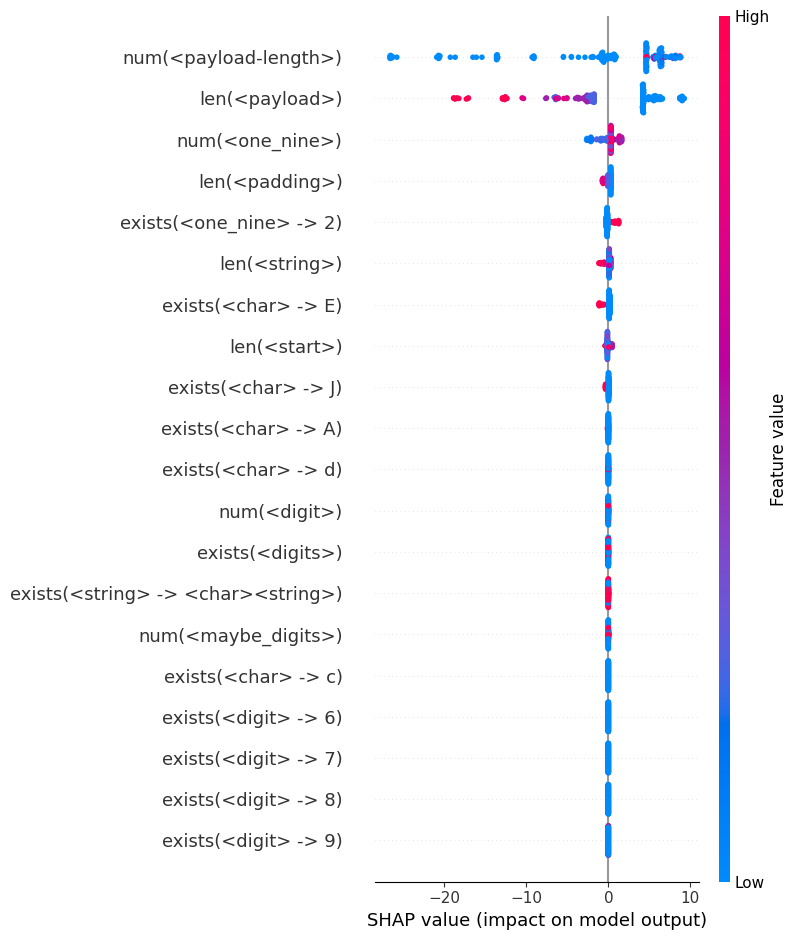

root :: 2023-08-10 21:17:34,864 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:17:34,867 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:17:35,107 :: INFO     :: Keeping 2 positive examples for candidate generation.
learner :: 2023-08-10 21:17:35,173 :: INFO     :: Found 153 invariant candidates.
learner :: 2023-08-10 21:17:35,174 :: INFO     :: Evaluating Recall.
learner :: 2023-08-10 21:17:49,162 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:17:49,249 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:17:49,730 :: INFO     :: Found 5 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:17:49,731 :: INFO     :: Eval new stuff
avicenna :: 2023-08-10 21:17:49,747 :: INFO     :: Starting Iteration 7
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


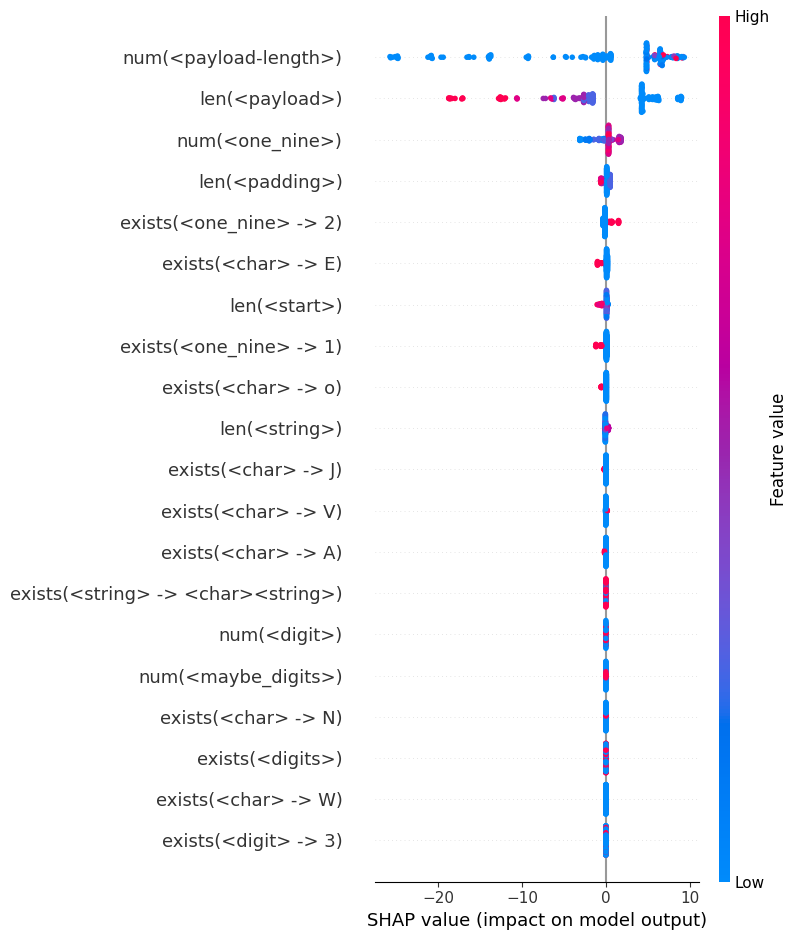

root :: 2023-08-10 21:17:50,456 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:17:50,459 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:17:50,789 :: INFO     :: Keeping 2 positive examples for candidate generation.
learner :: 2023-08-10 21:17:50,858 :: INFO     :: Found 153 invariant candidates.
learner :: 2023-08-10 21:17:50,858 :: INFO     :: Evaluating Recall.
learner :: 2023-08-10 21:18:06,800 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:18:06,870 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:18:07,371 :: INFO     :: Found 5 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:18:07,372 :: INFO     :: Eval new stuff
avicenna :: 2023-08-10 21:18:07,389 :: INFO     :: Starting Iteration 8
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


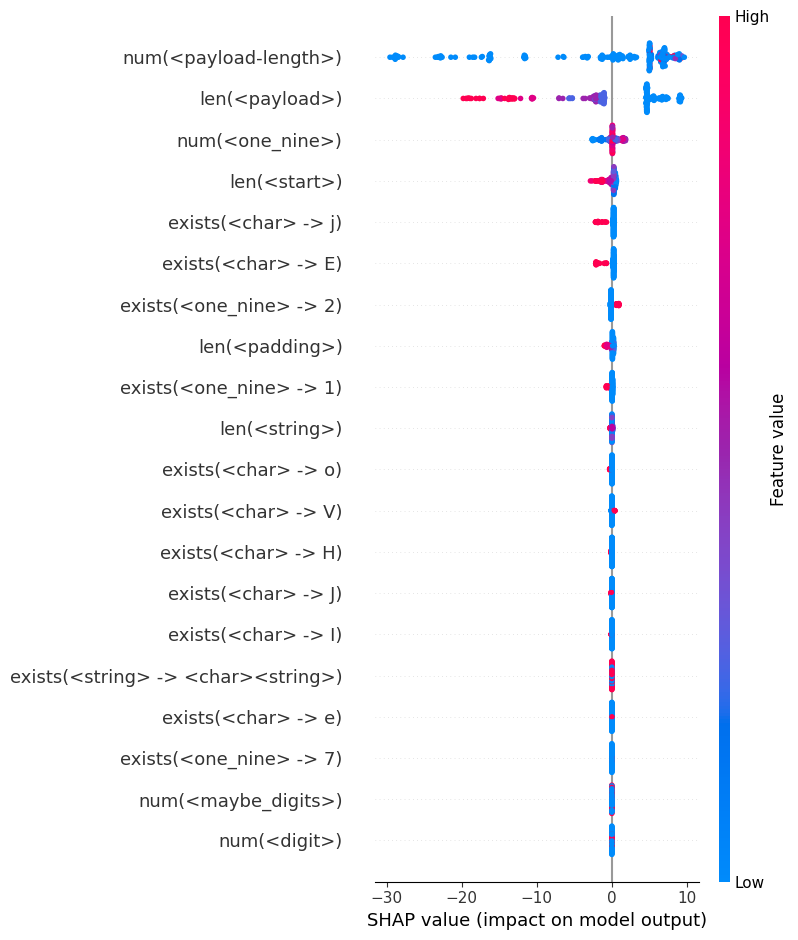

root :: 2023-08-10 21:18:08,172 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:18:08,175 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:18:08,479 :: INFO     :: Keeping 2 positive examples for candidate generation.
learner :: 2023-08-10 21:18:08,545 :: INFO     :: Found 153 invariant candidates.
learner :: 2023-08-10 21:18:08,545 :: INFO     :: Evaluating Recall.
learner :: 2023-08-10 21:18:25,560 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:18:25,628 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:18:26,145 :: INFO     :: Found 5 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:18:26,146 :: INFO     :: Eval new stuff
avicenna :: 2023-08-10 21:18:26,163 :: INFO     :: Starting Iteration 9
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


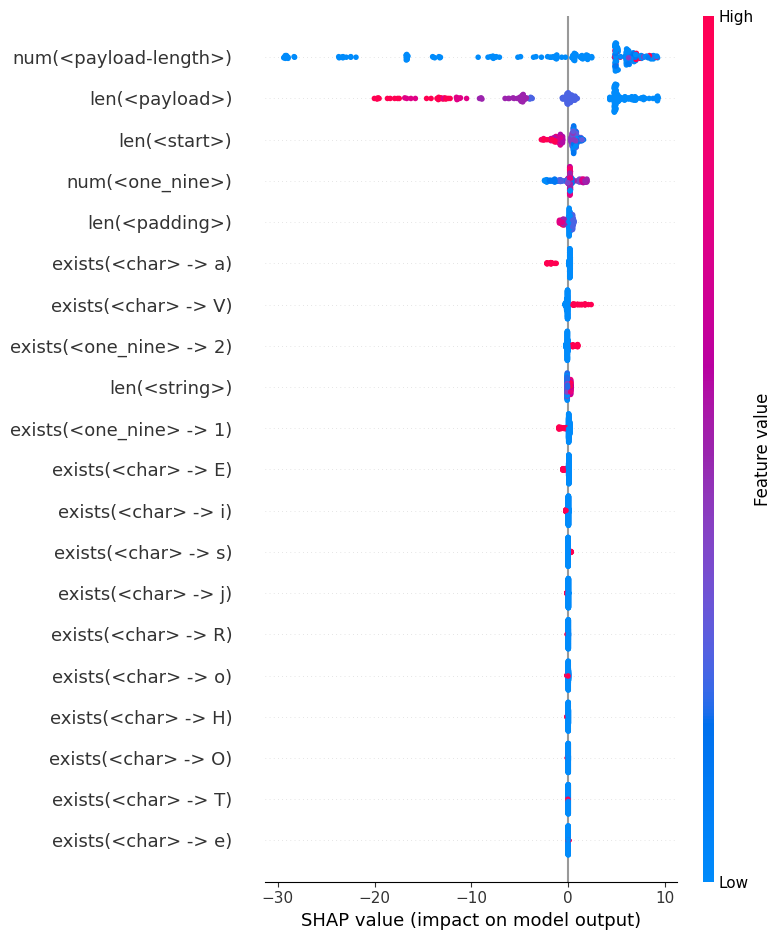

root :: 2023-08-10 21:18:27,011 :: INFO     :: Determined {len(<payload>), num(<payload-length>)} as most relevant.
root :: 2023-08-10 21:18:27,015 :: INFO     :: Added Features: {num(<maybe_digits>), exists(<digit>), len(<digit>), len(<maybe_digits>), exists(<maybe_digits> -> <digits>), num(<payload-length>), exists(<maybe_digits> -> ), num(<digits>), len(<digits>), num(<digit>), len(<payload>), exists(<digits> -> <digit>), exists(<digits>), len(<payload-length>)} due to high correlation.


{'<digit>', '<maybe_digits>', '<payload-length>', '<payload>', '<digits>'}
['<start>', '<heartbeat-request>', '<one_nine>', '<padding>', '<string>', '<char>']


learner :: 2023-08-10 21:18:27,437 :: INFO     :: Keeping 2 positive examples for candidate generation.
learner :: 2023-08-10 21:18:27,514 :: INFO     :: Found 158 invariant candidates.
learner :: 2023-08-10 21:18:27,514 :: INFO     :: Evaluating Recall.
learner :: 2023-08-10 21:18:46,081 :: INFO     :: Evaluating Precision.
learner :: 2023-08-10 21:18:46,160 :: INFO     :: Calculating Boolean Combinations.
learner :: 2023-08-10 21:18:46,781 :: INFO     :: Found 5 invariants with precision >= 60% and recall >= 90%.
avicenna :: 2023-08-10 21:18:46,782 :: INFO     :: Eval new stuff
root :: 2023-08-10 21:18:46,797 :: INFO     :: Terminate due to maximal iterations reached
root :: 2023-08-10 21:18:46,798 :: INFO     :: Avicenna finished
root :: 2023-08-10 21:18:46,798 :: INFO     :: The best learned failure invariant(s):
root :: 2023-08-10 21:18:46,804 :: INFO     :: ((1.0, 1.0, 1.0)): exists <payload> container1 in start:
  exists <payload-length> length_field in start:
    (< (str.len co

exists <payload> container1 in start:
  exists <payload-length> length_field in start:
    (< (str.len container1) (str.to.int length_field))
(exists <payload-length> container1 in start:
   exists <payload-length> length_field in start:
     (< (str.len container1) (str.to.int length_field)) and
exists <payload> container in start:
  exists <payload-length> length_field_0 in start:
    (<= (str.len container) (str.to.int length_field_0)))
(exists <payload> container in start:
   exists <payload-length> length_field in start:
     (<= (str.len container) (str.to.int length_field)) and
forall <payload-length> elem in start:
  (>= (str.to.int elem) (str.to.int "2")))
forall <payload-length> elem in start:
  (>= (str.to.int elem) (str.to.int "4"))
(exists <payload> container in start:
   exists <payload-length> length_field in start:
     (<= (str.len container) (str.to.int length_field)) and
forall <payload-length> elem in start:
  (>= (str.to.int elem) (str.to.int "4")))


In [12]:
from avicenna.avicenna import Avicenna
from avicenna_formalizations.heartbeat import initial_inputs, oracle

from isla.language import ISLaUnparser

avicenna = Avicenna(
    grammar=grammar,
    initial_inputs=initial_inputs,
    oracle=oracle,
    max_iterations=10,
)

diagnoses = avicenna.explain()

for diagnosis in diagnoses:
    print(ISLaUnparser(diagnosis[0]).unparse())

In [13]:
for inp in avicenna.all_inputs:
    print(inp, inp.oracle)

 9 u X BUG
 7 P xM BUG
 2 u Go BUG
 4 Qv N BUG
 55 V t BUG
 97 Gm ZF BUG
 60 OH K BUG
 5 D kUBL BUG
 321 T HjvRK BUG
 4 Nsz q BUG
 3 NdRM Po NO_BUG
 25 ITVv ii BUG
 8 FE Pd BUG
 8 oaWz i BUG
 8 K RcFQM BUG
 3 R bN BUG
 1 Gt BGYcY NO_BUG
 290 ET v BUG
 558 ictI SH BUG
 2 jRAEG M NO_BUG
 6 RC U BUG
 44 a yCA BUG
 73 N fZT BUG
 9 s m BUG
 3 J ey BUG
 22 F F BUG
 1 c y NO_BUG
 5 ms bS BUG
 747 WfKwnpl G BUG
 254 NT I BUG
 4 tUSEv Oq NO_BUG
 31 yzLqIxuV T BUG
 7 tE v BUG
 88 vRs dDBVJ BUG
 94 WKQ vl BUG
 7 l SNr BUG
 1508 NFVpoLyu U BUG
 5 TJ Ny BUG
 73 Tg WmSbg BUG
 8 x V BUG
 36 c kF BUG
 81 QH JM BUG
 5050 r s BUG
 53 xB j BUG
 8 F SQ BUG
 65 HB HjLTw BUG
 6 p Q BUG
 2 jNf V NO_BUG
 4 A OlkRaa BUG
 5 Nt MrZr BUG
 793 XedQn Rko BUG
 2 Y z BUG
 44393 NiH KgWM BUG
 5 Q op BUG
 4 o Zey BUG
 86 l hQ BUG
 92 W i BUG
 84 EG du BUG
 52 OKD l BUG
 428 N H BUG
 9 N GVu BUG
 7228 zn s BUG
 5 vjO G BUG
 6 Mj C BUG
 9 Mt ivrV BUG
 4 bJ

In [14]:
from isla.solver import ISLaSolver

constraint = """
exists <payload> container1 in start:
  exists <payload-length> length_field in start:
    (< (str.len container1) (str.to.int length_field))
"""
solver = ISLaSolver(grammar, constraint)

for inp in avicenna.all_inputs:
    bool_ = True if inp.oracle == OracleResult.BUG else False
    solver_result = solver.check(str(inp))
    if bool_ != solver_result:
        print(str(inp).encode())
    # print(str(inp).encode(), inp.oracle, solver.check(str(inp)))